In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\nishi\Desktop\Projects\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:

df = pd.read_csv('dataset.csv')

In [3]:

#preprocessing
df.drop(columns='customerID', axis=1, inplace=True)
#Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 3. Fill missing TotalCharges (these are likely new customers with tenure = 0)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# 4. Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 5. Check for any other missing values and handle them
print("Missing values after handling TotalCharges:")
print(df.isnull().sum())
df.dropna(inplace=True)

Missing values after handling TotalCharges:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [4]:
#  Feature Engineering 
df['Tenure_to_Charge_Ratio'] = df['tenure'] / (df['MonthlyCharges'] + 1)
df['Avg_Monthly_Charge'] = df['TotalCharges'] / (df['tenure'] + 1)
df['Is_Long_Tenure'] = (df['tenure'] > 12).astype(int)
df['High_Value_Customer'] = ((df['MonthlyCharges'] > df['MonthlyCharges'].median()) & 
                             (df['tenure'] > 6)).astype(int)


In [5]:
# Encode categorical variables properly
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 
               'PaperlessBilling', 'MultipleLines', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies']

# Label encode binary columns
le = LabelEncoder()
for col in binary_cols:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# One-hot encode other categorical variables
nominal_cols = ['InternetService', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [6]:
#Prepare features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [7]:
# Check class distribution
print(f"\nClass distribution:\n{y.value_counts(normalize=True)}")


Class distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [8]:
#  Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# Scale numerical features (NO DATA LEAKAGE)
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 
                  'Tenure_to_Charge_Ratio', 'Avg_Monthly_Charge']


numerical_cols = [col for col in numerical_cols if col in X_train.columns]

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [10]:
#Handle class imbalance using class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\nClass weights: {class_weight_dict}")


Class weights: {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}


In [11]:
#  Build a better ANN model
model = Sequential()

# Input layer
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden layers
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())

# Output layer
model.add(Dense(1, activation='sigmoid'))

c:\Users\nishi\Desktop\Projects\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
#Compile with better optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 224 (896.00 B)

In [13]:
# 13. Add callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]


In [14]:
# 14. Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6680 - auc: 0.7447 - loss: 0.6074 - precision: 0.4257 - recall: 0.7067 - val_accuracy: 0.6525 - val_auc: 0.8037 - val_loss: 0.6130 - val_precision: 0.4099 - val_recall: 0.8000 - learning_rate: 0.0010
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7280 - auc: 0.8149 - loss: 0.5292 - precision: 0.4931 - recall: 0.7726 - val_accuracy: 0.6897 - val_auc: 0.8079 - val_loss: 0.5897 - val_precision: 0.4419 - val_recall: 0.7862 - learning_rate: 0.0010
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7426 - auc: 0.8267 - loss: 0.5146 - precision: 0.5110 - recall: 0.7748 - val_accuracy: 0.6986 - val_auc: 0.8075 - val_loss: 0.5858 - val_precision: 0.4494 - val_recall: 0.7655 - learning_rate: 0.0010
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7515 - auc: 0.8365 - loss: 0.4999 - precision: 0.5220 - recall: 0.7896 - val_accuracy: 0.7004 - val_auc: 0.8055 - val_loss: 0.5554 

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MODEL PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1035
           1       0.48      0.86      0.61       374

    accuracy                           0.71      1409
   macro avg       0.70      0.76      0.69      1409
weighted avg       0.81      0.71      0.73      1409


Confusion Matrix:


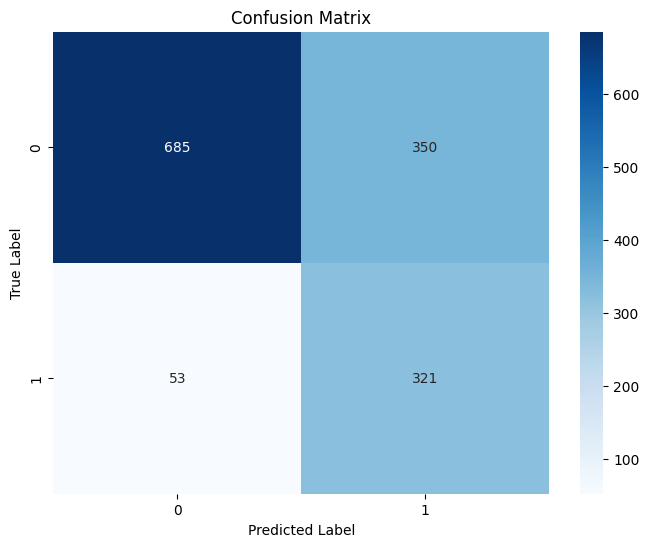

ROC-AUC Score: 0.8422


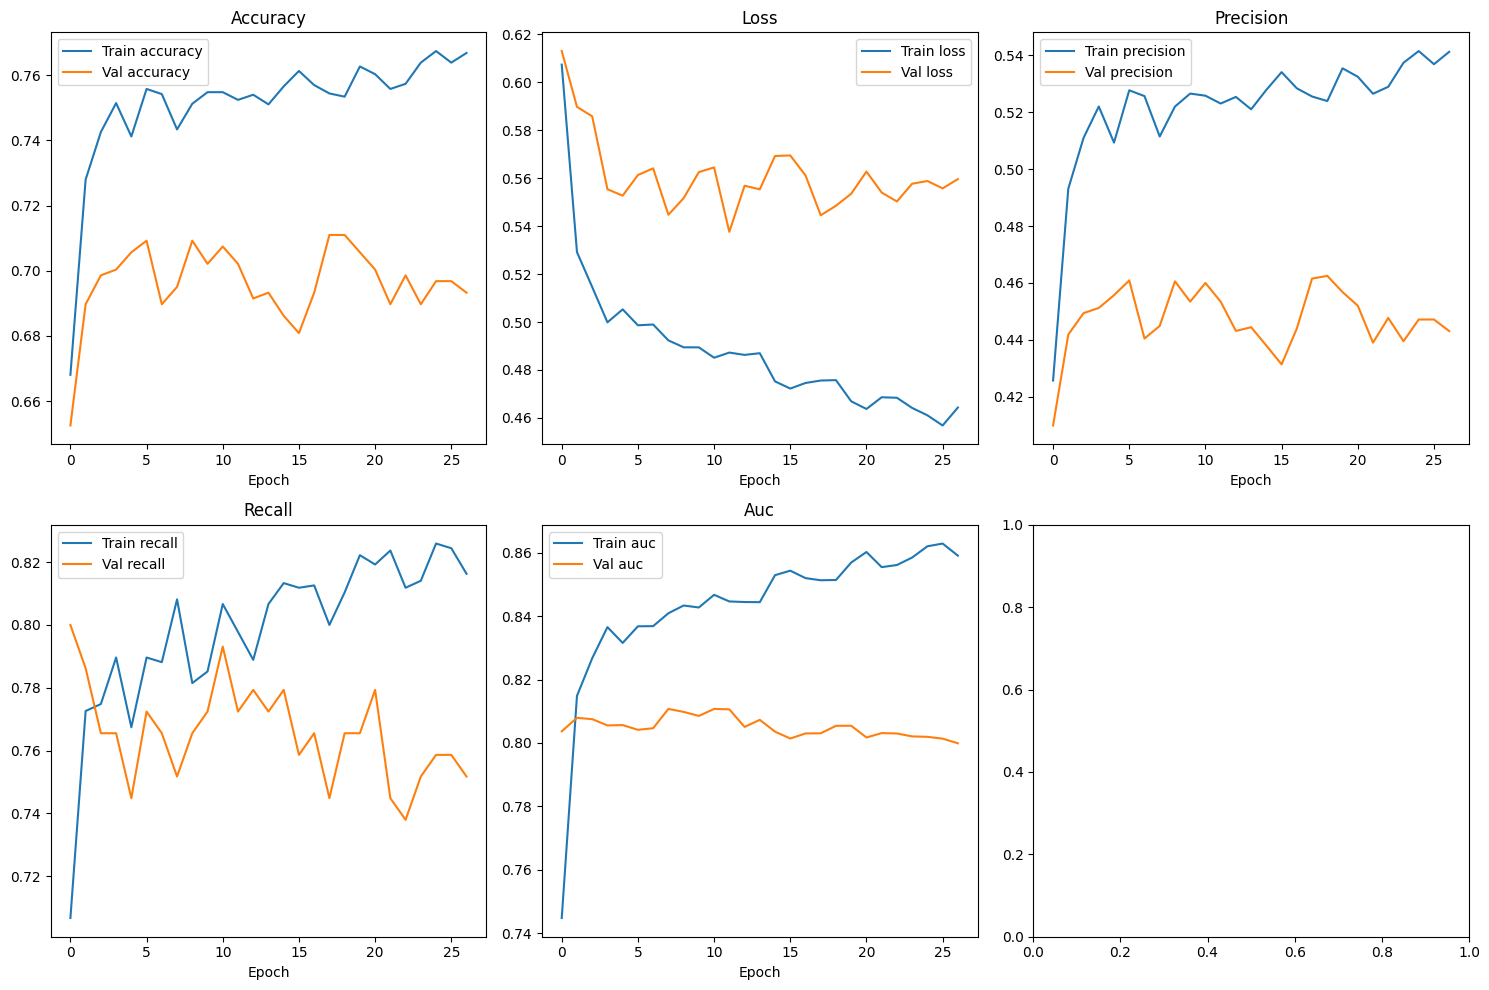

In [20]:
# 15. Evaluate the model
def evaluate_model(model, X_test, y_test):
    """Comprehensive evaluation"""
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.45).astype(int)
    
    print("=" * 60)
    print("MODEL PERFORMANCE")
    print("=" * 60)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    # Plot training history
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    for i, metric in enumerate(metrics):
        row, col = i // 3, i % 3
        axes[row, col].plot(history.history[metric], label=f'Train {metric}')
        axes[row, col].plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        axes[row, col].set_title(f'{metric.capitalize()}')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].legend()
    
    plt.tight_layout()
    plt.show()
    
    return y_pred_proba

# Run evaluation
y_pred_proba = evaluate_model(model, X_test, y_test)

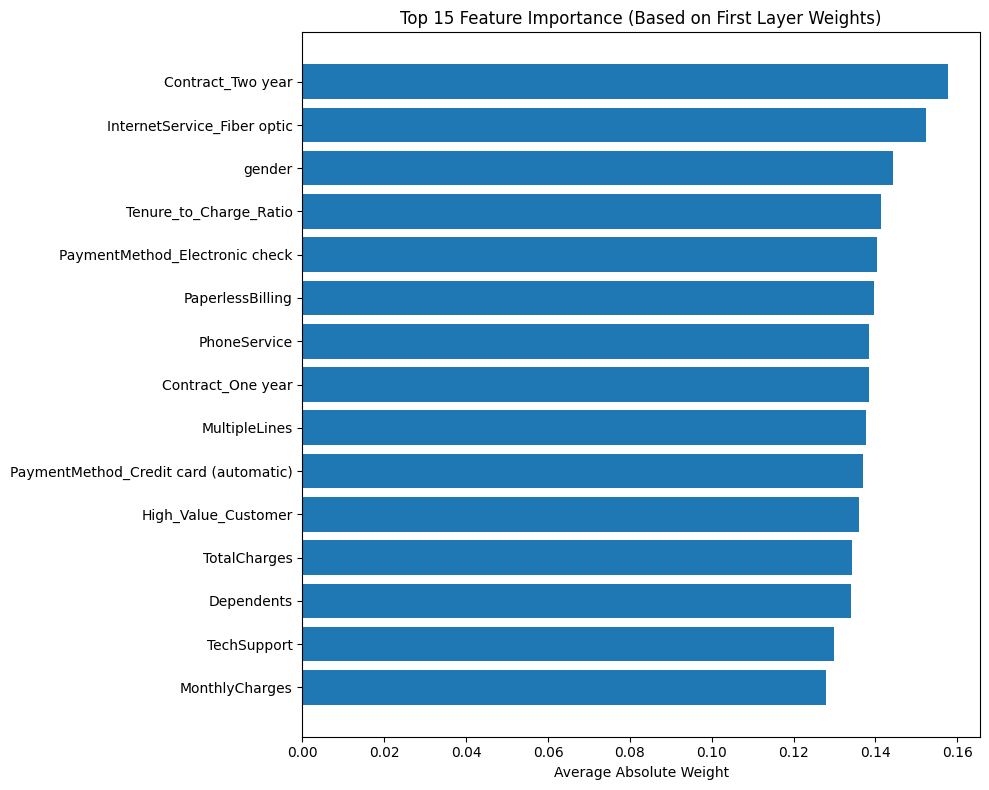

In [21]:
# 16. Feature importance 
# Create a simple feature importance plot
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Average Absolute Weight')
plt.title('Top 15 Feature Importance (Based on First Layer Weights)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:
# Save model
model.save('churn_model.keras')

# Save scaler and encoders
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']